#### Imports

In [3]:
# Core imports
from copy import deepcopy
import os
import math
import importlib

# Installed imports
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import matplotlib as mpl
import functools
from IPython.display import HTML
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser
from src.utils.delayer import Delayer
import src.learning.training_utils
import src.learning.networks
import src.utils.data_loading
import src.utils.data_processing
import src.utils.experiment_utils

importlib.reload(src.utils.data_loading)
importlib.reload(src.utils.data_processing)
importlib.reload(src.learning.training_utils)
importlib.reload(src.learning.networks)
importlib.reload(src.utils.experiment_utils)

from src.learning.training_utils import *
from src.learning.networks import *
from src.utils.data_loading import *
from src.utils.data_processing import *
from src.utils.experiment_utils import * 


#### Parameters for our experiments

In [4]:
# Parameters to have around
seconds_per_TR = 2.0045

# Experiment parameters
k_closest_vehicles = 3
k_closest_pedestrians = 0
ROIs_to_include = ["IPS", "PPA", "RSC"]
perform_pca = True
n_features_brain_pca = 30
delays = [0]
include_brain_data = True
use_filtered = False
brain_loss_weight = 1.0

n_steps_ahead = [15, 30, 45, 60, 75, 90]
brain_lookahead = 15 * np.array([0, seconds_per_TR, seconds_per_TR * 2, seconds_per_TR * 3, seconds_per_TR * 4])
brain_lookahead = np.array([round(x) for x in brain_lookahead]) # round them to nearest sample numbers

# Training parameters
n_epochs = 30
batch_size = 64
hidden_layer_sizes = [32, 32, 32, 32, 32]
learning_rate = 0.0001

# IDS of the demonstrations to use for training, validation, and testing
train_ids = np.load(f"./Data/Demonstrations/train_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
validation_ids = np.load(f"./Data/Demonstrations/validation_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
test_ids = np.load(f"./Data/Demonstrations/test_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
all_ids = np.concatenate((train_ids, validation_ids, test_ids))

# So that we can skip loading the parsers 
parsers_loaded = True

#### Load our various datasets
Load train, validation, and test demonstration trajectories 

In [5]:
train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

Load brain data

In [6]:
# Specify the files 
# use the filtered brain data
if use_filtered:
    brain_filenames = [f"./Data/BrainData/{id}_combined data_filtered_removed_['fixation_related', 'low_level_vision', 'high_level_vision', 'motor', 'motor_plans'].npy" for id in all_ids]
else:
    brain_filenames = [f"./Data/BrainData/{id}_combined data.npy" for id in all_ids]
brain_data = load_brain_data(brain_filenames)

# Put the brain data in a dictionary mapping from brain_id to brain data
brain_data_dict = {}
for i in range(len(all_ids)):
    brain_data_dict[all_ids[i]] = brain_data[i]

# Restrict to the desired ROIs
for id in brain_data_dict.keys():
    brain_data_dict[id] = restrict_to_ROIs(brain_data_dict[id], ROIs_to_include)

brain_data_dim = brain_data_dict[all_ids[0]].shape[1]


In [7]:
if not parsers_loaded: 
    # Load the associated parsers as well 
    parser_filenames = [f"./Data/LogAndLabelData/{id}_positions.xml" for id in all_ids]
    parsers = load_log_data(parser_filenames)

    # Put the parsers in a dictionary mapping from run_id to parser
    parser_dict = {}
    for i in range(len(all_ids)):
        parser_dict[all_ids[i]] = parsers[i]

Total percent explained variance:  65.83086559876634


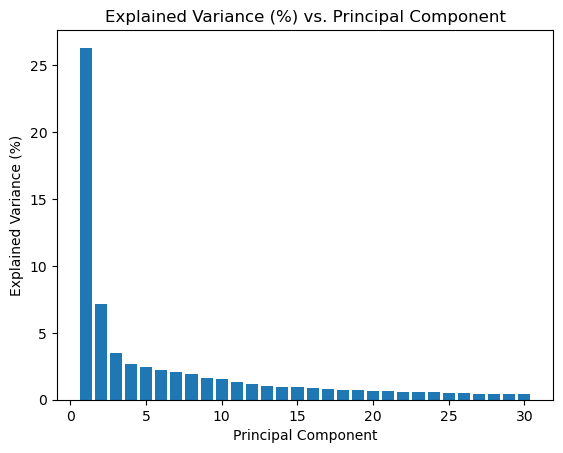

In [8]:
# Perform PCA on the brain data 
if perform_pca:
    # Just use the training brain data for PCA
    train_brain_data = [brain_data_dict[id] for id in train_ids]

    # Stack the training brain data to perform PCA
    stacked_train_brain_data = np.vstack(train_brain_data)

    # Now, create a dictionary representing all of the 
    # brain dat 
    pca_brain = pca(stacked_train_brain_data, n_features_brain_pca, plot_variance=True)
    pca_brain_dict = {}
    for id in brain_data_dict.keys():
        pca_brain_dict[id] = pca_brain.transform(brain_data_dict[id])

    brain_data_dim = n_features_brain_pca

    brain_data_dict = pca_brain_dict

#### Do any pre-processing to the state that we'd like. For instance, here we can turn things into an ego-centric frame.


In [9]:
 # Pull out just the states, make the centerline direction adjustments, then convert to line frame
 train_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration, k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration, k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstration_states_world_frame]

Interpolate the brain data to match the length of the demonstrations

In [10]:
interpolated_brain_data_dict = {}
for id in brain_data_dict.keys():
    interpolated_brain_data_dict[id] = interpolate_brain_data(brain_data_dict[id], parser_dict[id], parser_dict[id].nFrames)

#### Create outputs your input, output pairs for training.

For now, these will be state-based for the ego vehicle but this could also be the control actions. It's like we're picturing the control-space as the next 2-d position, angle, and speed. 

In [11]:
# Depending on whether we'd like to do world frame or line frame
world_frame = False

if world_frame:
    # How far ahead you're trying to predict and which columns you'd like to predict
    cols_to_predict = [0, 1, 2, 3]
    training_pairs = [prediction_input_and_output(demonstration, n_steps_ahead, cols_to_predict) for demonstration in train_demonstration_states_world_frame]
    validation_pairs = [prediction_input_and_output(demonstration, n_steps_ahead, cols_to_predict) for demonstration in validation_demonstration_states_world_frame]

else:
    training_pairs = [line_frame_to_training_matrices(demonstration_line_frame, k_closest_vehicles, k_closest_pedestrians, n_steps_ahead, delays, include_brain_data=include_brain_data, interpolated_brain_data_dict=interpolated_brain_data_dict, brain_lookahead=brain_lookahead, all_ids=all_ids) for demonstration_line_frame in train_demonstration_states_line_frame]
    validation_pairs = [line_frame_to_training_matrices(demonstration_line_frame, k_closest_vehicles, k_closest_pedestrians, n_steps_ahead, delays, include_brain_data=include_brain_data, interpolated_brain_data_dict=interpolated_brain_data_dict, brain_lookahead=brain_lookahead, all_ids=all_ids) for demonstration_line_frame in validation_demonstration_states_line_frame]
    
# Then, stack these X, Y pairs to get the final training data
X_train = np.vstack([pair[0] for pair in training_pairs])
Y_train = np.vstack([pair[1] for pair in training_pairs])   
X_validation = np.vstack([pair[0] for pair in validation_pairs])
Y_validation = np.vstack([pair[1] for pair in validation_pairs])

# Normalize the data, both train and validation
X_train_mean, X_train_std = find_normalization(X_train)
Y_train_mean, Y_train_std = find_normalization(Y_train)

X_train = normalize_matrix(X_train, X_train_mean, X_train_std)
Y_train = normalize_matrix(Y_train, Y_train_mean, Y_train_std)

X_validation = normalize_matrix(X_validation, X_train_mean, X_train_std)
Y_validation = normalize_matrix(Y_validation, Y_train_mean, Y_train_std)

Apply supervised learning to map between our X and Y

Finished epoch 0, latest losses [0.99443203 1.99106109], validation losses [1.04165232 2.27681065]
Finished epoch 1, latest losses [0.94678402 1.92516255], validation losses [0.99094361 2.22985148]
Finished epoch 2, latest losses [0.86576831 1.83344579], validation losses [0.90841693 2.15192604]
Finished epoch 3, latest losses [0.8081646  1.76941323], validation losses [0.85253364 2.09457088]
Finished epoch 4, latest losses [0.78160226 1.73771048], validation losses [0.82434368 2.06430721]
Finished epoch 5, latest losses [0.76874995 1.7202909 ], validation losses [0.81481034 2.05504775]
Finished epoch 6, latest losses [0.7611919  1.70891094], validation losses [0.81364632 2.05515385]
Finished epoch 7, latest losses [0.75547987 1.70002139], validation losses [0.81506288 2.05797768]
Finished epoch 8, latest losses [0.75079447 1.69268334], validation losses [0.81223482 2.05710649]
Finished epoch 9, latest losses [0.74660921 1.68618989], validation losses [0.82183093 2.06863451]
Finished e

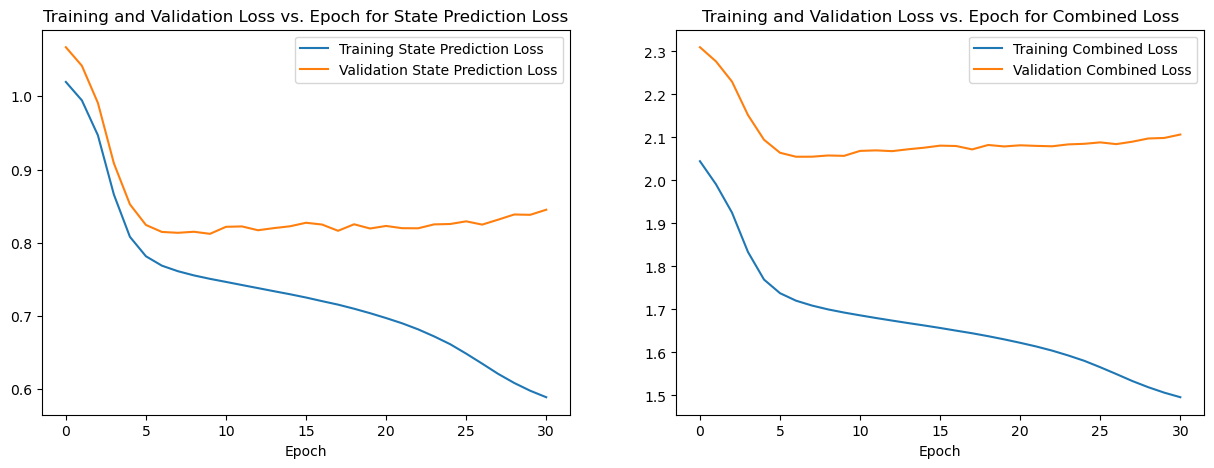

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
Y_validation = torch.tensor(Y_validation, dtype=torch.float32)

# Get the dimensions of the predicted states we're mapping to and
# the brain data written down so that our layer sizes can be right in the model
state_pred_dim = 2*len(n_steps_ahead) # copies of delta x and delta y output
brain_dim = brain_data_dim * len(brain_lookahead) if include_brain_data else 0 # copies of brain data

# Choose your loss(es) for training and evaluation
brain_loss = BrainLoss(state_pred_dim, brain_dim, brain_loss_weight)
pred_loss = PredLoss(state_pred_dim)
if include_brain_data:
    train_loss = brain_loss 
else:
    train_loss = pred_loss

eval_losses = [pred_loss, brain_loss]
labels=["State Prediction Loss", "Combined Loss"]

model = MLP([X_train.shape[1], *hidden_layer_sizes, state_pred_dim], add_latent_to_brain=include_brain_data, brain_dim=brain_dim)
supervised_learning(X_train, Y_train, X_validation, Y_validation, model, n_epochs, batch_size, train_loss, eval_losses, labels, lr=learning_rate)

# After training, turn off the brain data outputs
model.add_latent_to_brain = False

# Update X_train and Y_train to just have the first state_pred_dim values
# to work with the rest of animations and stuff
# TODO: incorporate this into the model. 
Y_train_mean, Y_train_std = Y_train_mean[0:state_pred_dim], Y_train_std[0:state_pred_dim]

#### Helper functions for plotting and examining the learned model

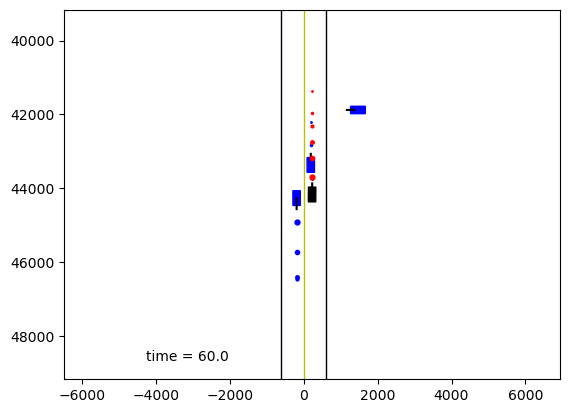

In [13]:
percent_to_animate=0.1
render_speedup = 8.0
subsample = 15
demonstration = train_demonstration_states_line_frame[0]
rollout_states, all_predictions = rollout_prediction_line_frame(demonstration, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, delays, k_closest_vehicles, k_closest_pedestrians)
anim = animate_trajectory(demonstration, rollout_states, all_predictions, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=percent_to_animate, render_speedup=render_speedup, subsample=subsample, export_as_gif=False, filename=f"./Output/animation_train_{i}")
anim

visualize_points_through_trajectory(demonstration, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, subsample, output_dir="./Output/test/", start_filename="testetst")



Animations of the performance

not enough time to animate (can't get ground truth next states for long enough)


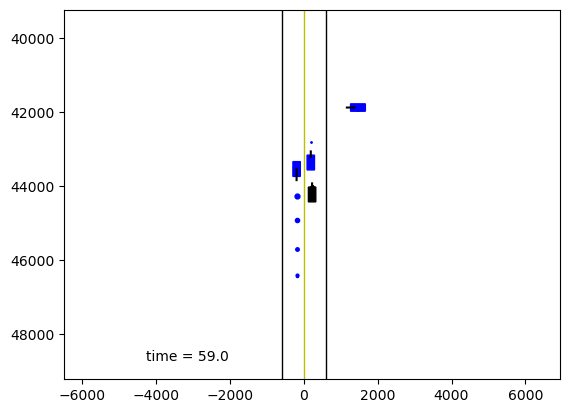

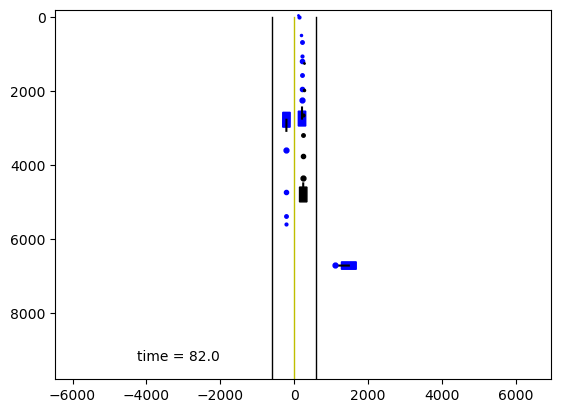

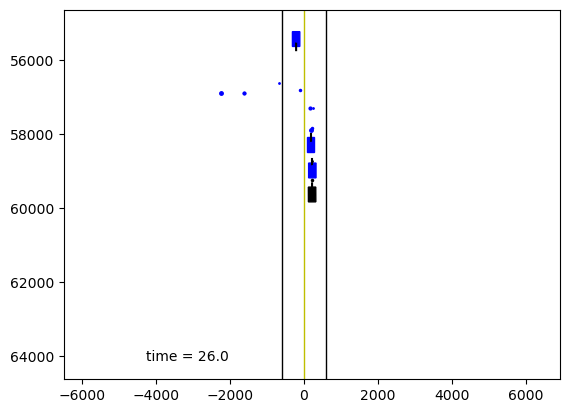

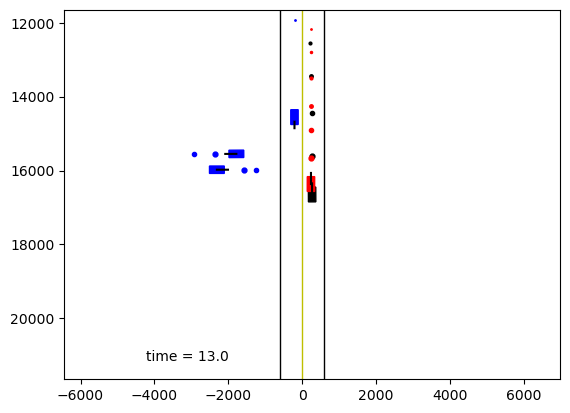

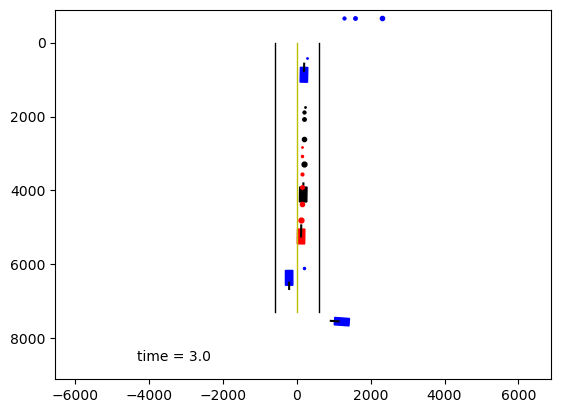

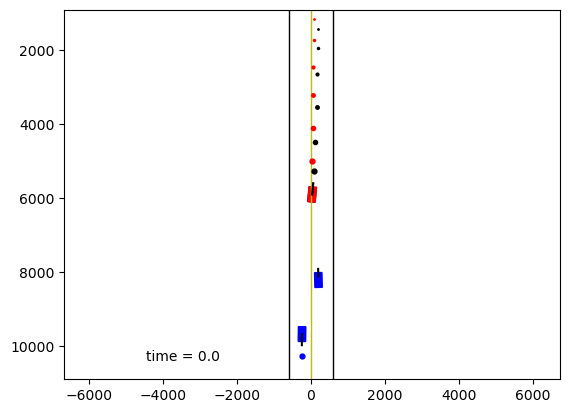

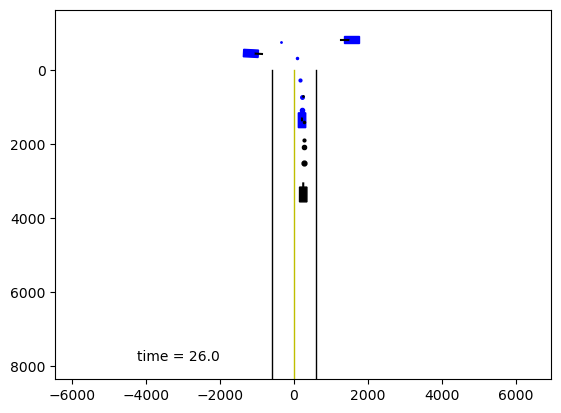

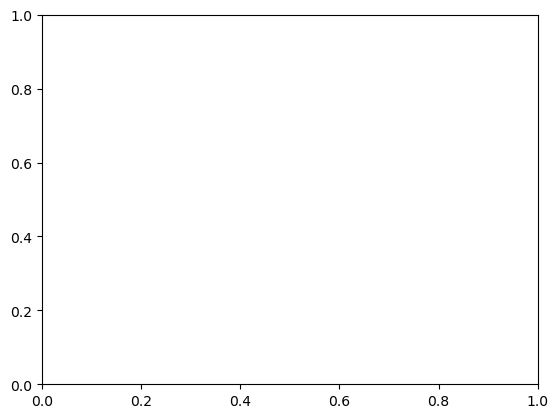

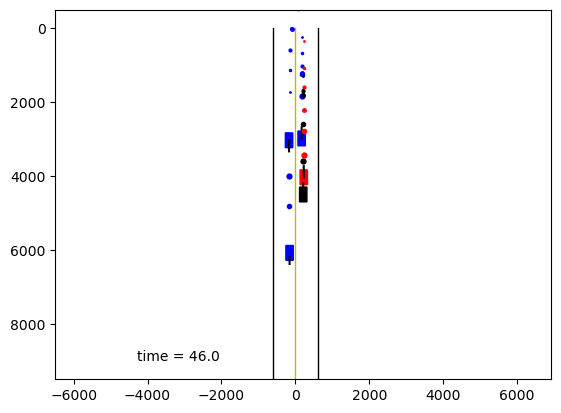

In [14]:
if ~world_frame:
    n_train_animations = 3
    n_validation_animations = 6
    export_as_gif = True
    percent_to_animate=1.0
    render_speedup = 8.0
    subsample = 15

    train_anims = []
    validation_anims = []
    for i in range(n_train_animations):
        demonstration_states = train_demonstration_states_line_frame[i]
        rollout_prediction, all_predictions = rollout_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, delays, k_closest_vehicles, k_closest_pedestrians)
        anim = animate_trajectory(demonstration_states, rollout_prediction, all_predictions, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=percent_to_animate, render_speedup=render_speedup, subsample=subsample, export_as_gif=export_as_gif, filename=f"./Output/animation_train_{i}")
        
        train_anims.append(anim)

    for i in range(n_validation_animations):
        demonstration_states = validation_demonstration_states_line_frame[i]
        rollout_prediction, all_predictions = rollout_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, delays, k_closest_vehicles, k_closest_pedestrians)
        anim = animate_trajectory(demonstration_states, rollout_prediction, all_predictions, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=percent_to_animate, render_speedup=render_speedup, subsample=subsample, export_as_gif=export_as_gif, filename=f"./Output/animation_validation_{i}")

        validation_anims.append(anim)


Total percent explained variance:  99.99999998679779
brain data dim:  5
use pca:  True
pca dim:  5
Finished epoch 0, latest losses [0.8036291 0.8036291], validation losses [0.82856196 0.82856196]
Finished epoch 1, latest losses [0.75171643 0.75171643], validation losses [0.80347437 0.80347437]
Finished epoch 2, latest losses [0.73311514 0.73311514], validation losses [0.83301079 0.83301079]
Finished epoch 3, latest losses [0.7094807 0.7094807], validation losses [0.80352646 0.80352646]
Finished epoch 4, latest losses [0.68231213 0.68231213], validation losses [0.81603569 0.81603569]
Finished epoch 5, latest losses [0.64906007 0.64906007], validation losses [0.81250703 0.81250703]
Finished epoch 6, latest losses [0.61128592 0.61128592], validation losses [0.82154226 0.82154226]
Finished epoch 7, latest losses [0.57487643 0.57487643], validation losses [0.85020536 0.85020536]
Finished epoch 8, latest losses [0.54158109 0.54158109], validation losses [0.89633524 0.89633524]
Finished epoch

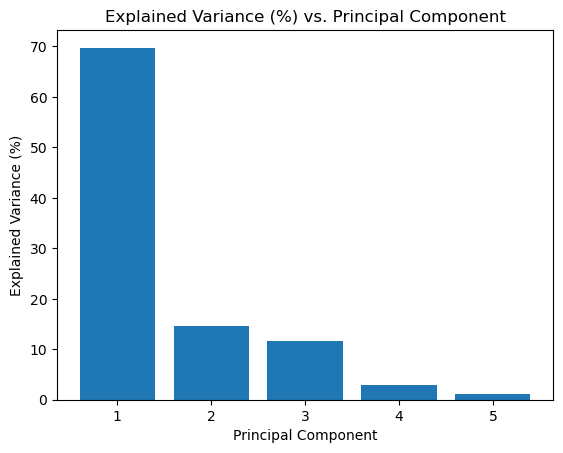

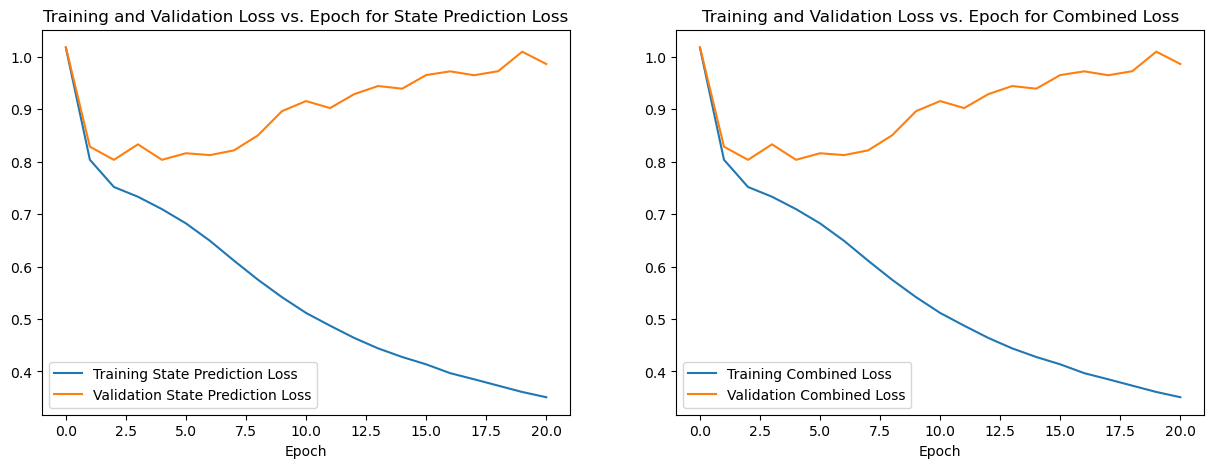

loading checkpoint  2
train animation  0
train animation  1
train animation  2
train animation  3
train animation  4
train animation  5
not enough time to animate (can't get ground truth next states for long enough)
train animation  6
not enough time to animate (can't get ground truth next states for long enough)
train animation  7
train animation  8
train animation  9
validation animation  0
validation animation  1
validation animation  2
validation animation  3
validation animation  4
not enough time to animate (can't get ground truth next states for long enough)
validation animation  5
validation animation  6
validation animation  7
validation animation  8
validation animation  9
not enough time to animate (can't get ground truth next states for long enough)


/Users/castrong/Desktop/Berkeley/Academics/Spring_2023/HRI/Final Project/DeepBrainIRL/deep_brain_irl/src/utils/visualization.py:258: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots()


<Figure size 640x480 with 0 Axes>

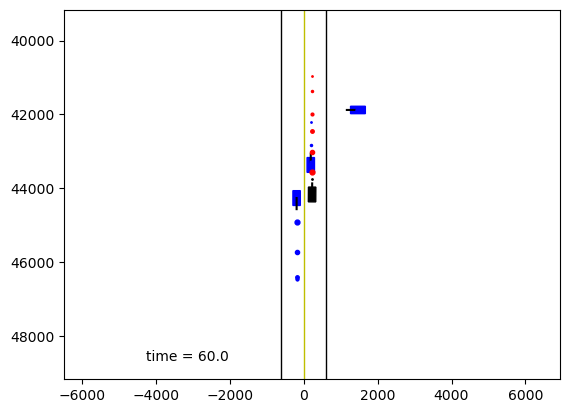

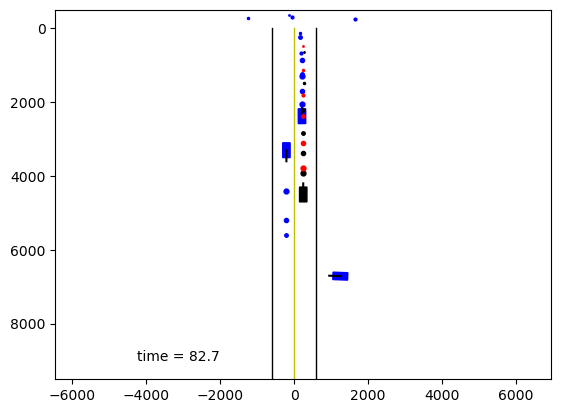

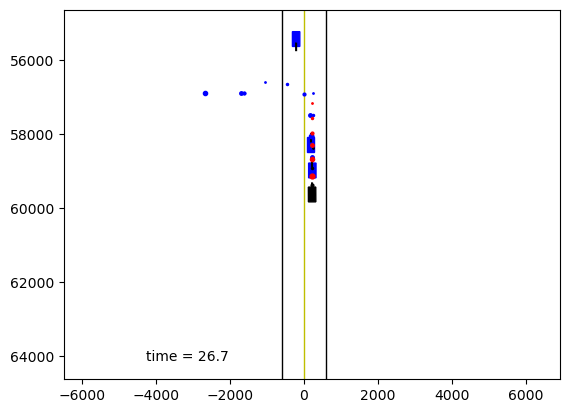

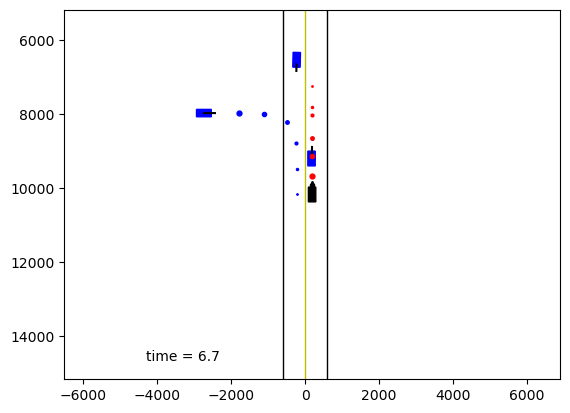

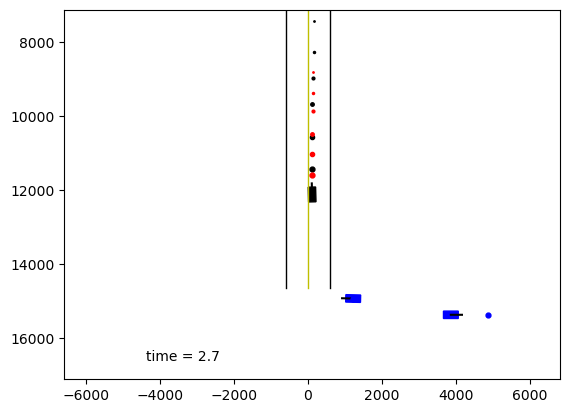

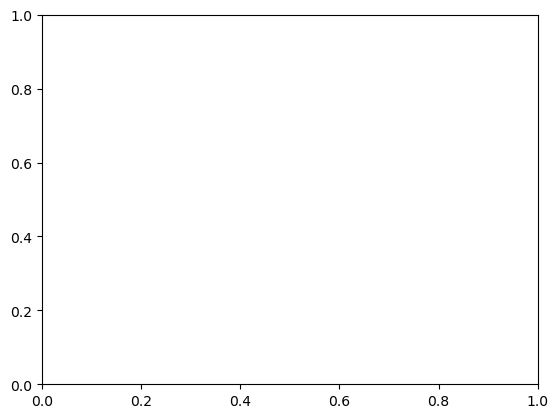

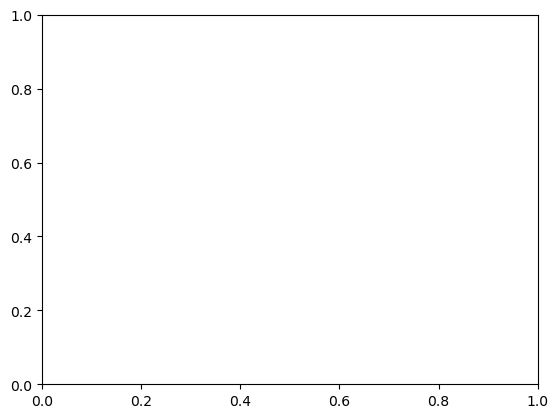

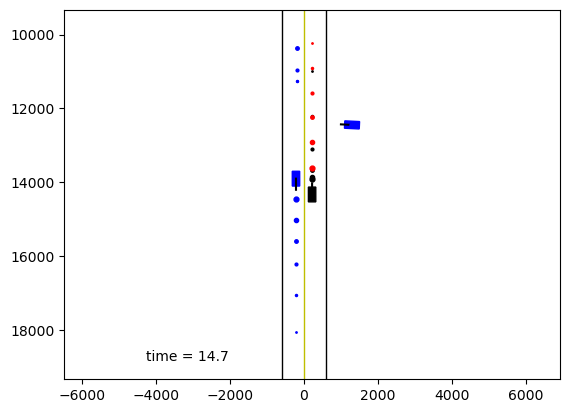

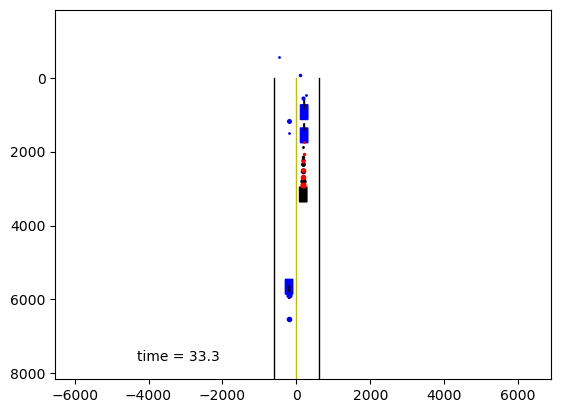

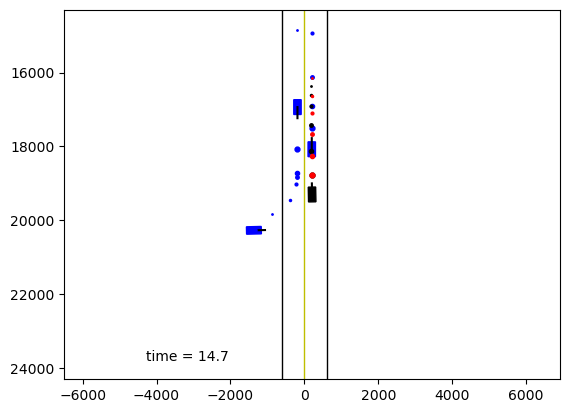

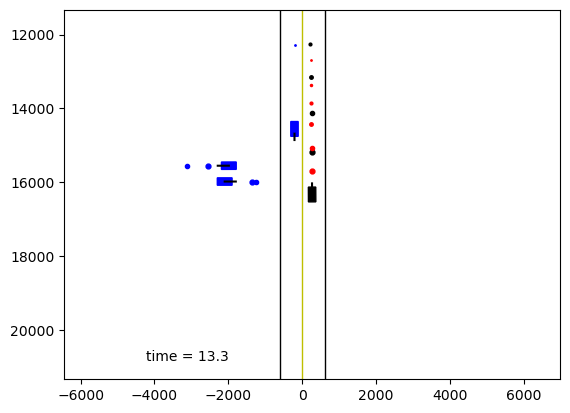

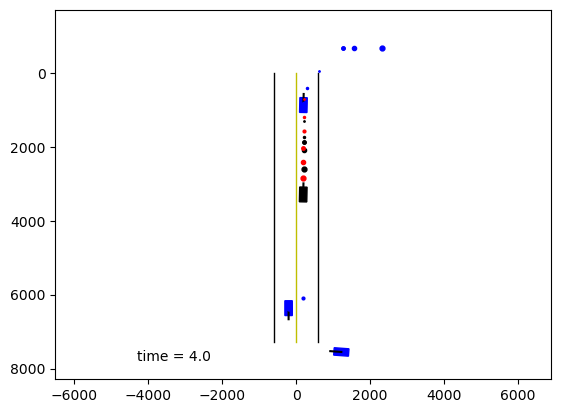

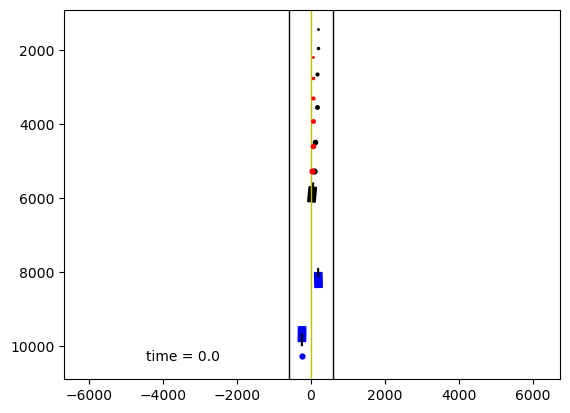

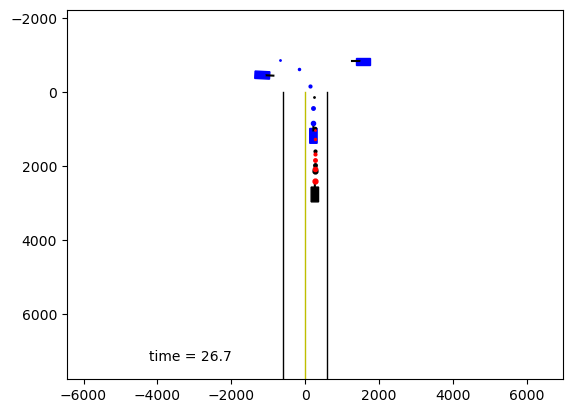

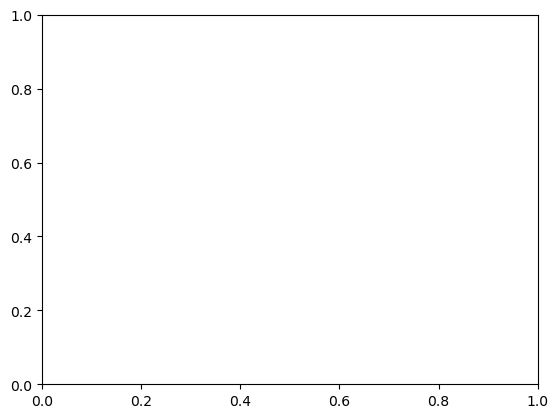

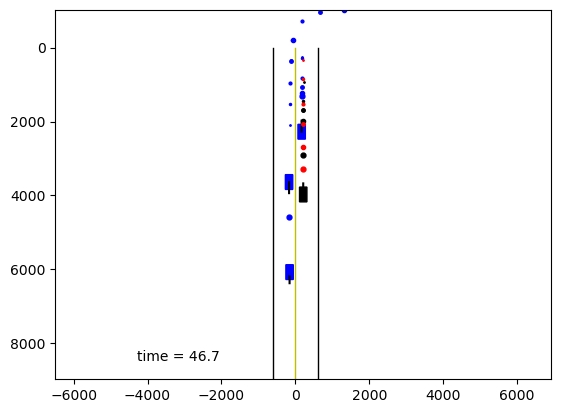

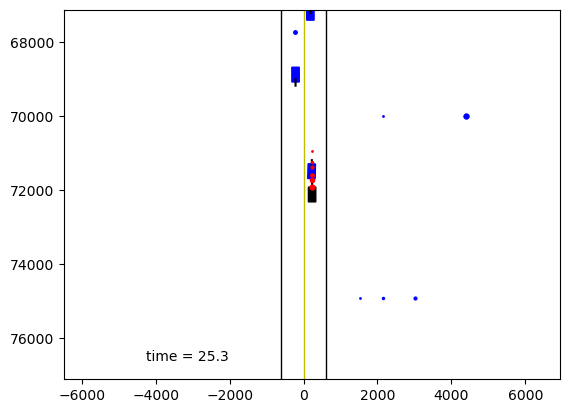

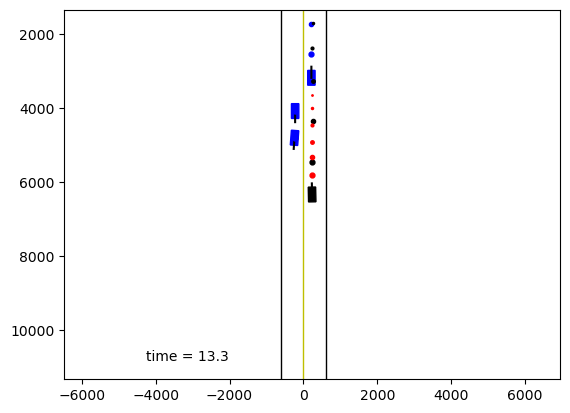

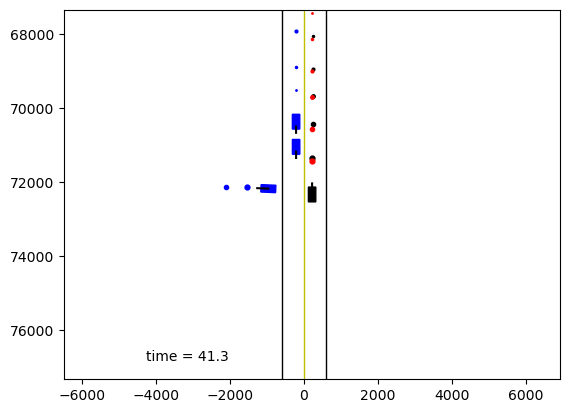

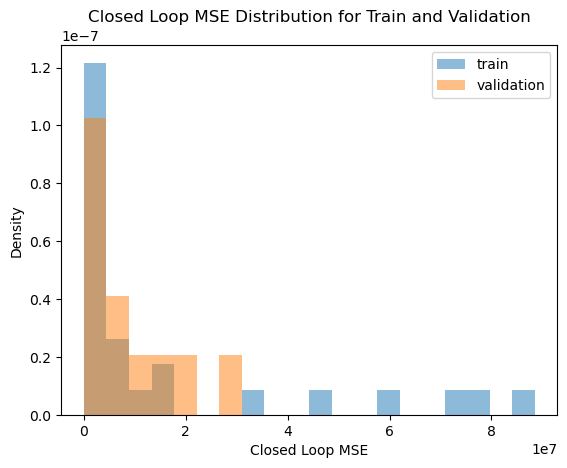

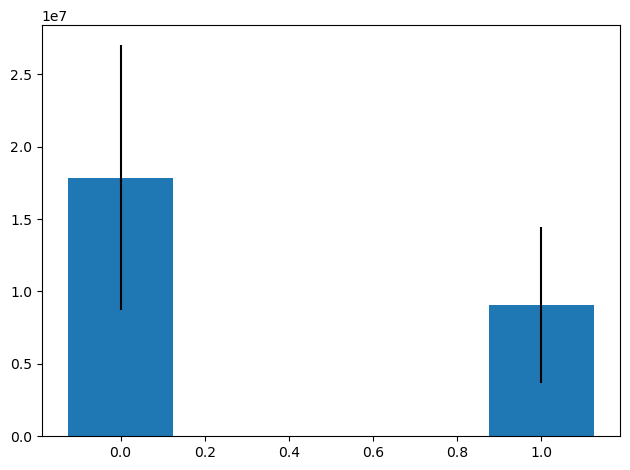

In [15]:

all_brain_regions = ["FEF", "FFA", "IPS", "OPA", "PPA", "RSC", "V1", "V2", "V3"]

train_losses, validation_losses, loss_labels, train_errors, validation_errors = train_evaluate_configuration(3, 0, 
                                                                                                all_brain_regions, True, 5, True, True, 0.0, 
                                                                                                [0], [15, 30, 45, 60, 75, 90], [0, 30, 60, 90],
                                                                                                20, 64, [32, 32, 32], 0.0005, 
                                                                                                parser_dict=parser_dict, animate=True, visualize_snapshots=True, subsample_animation=15, subsample_snapshots=20)

Interrogating how the network varies in a couple dimensions.

In [16]:
# TODO: rebuild this with the new delay and multiple predictions type of networks 

#### Setup specific experiments

start with varying the brain data weight during training, and then we can compare the minimum validation performance